In [1]:
# !pip install pandas numpy seaborn scipy openpyxl

In [2]:
import pandas as pd
import numpy as np
import seaborn.objects as so
import seaborn as sns
from scipy import stats
import math
from itertools import combinations
import typing
from functools import partial

In [3]:
xl_path = 'Planilha Suporte - Fundamentos de Estatisticaxlsx Portugues.xlsx'

# Fundamentos de Estatística

## Estatítica descritiva

### Qualitativos

In [4]:
qual_df = pd.read_excel(
    xl_path,
    sheet_name='Tabela de Frequências',
    usecols=[0,1],
)
qual_df.head()

,Indivíduo,País de Origem
0,1,Brasil
1,2,Inglaterra
2,3,Japão
3,4,EUA
4,5,Brasil


In [5]:
frequencies = (
    qual_df.loc[:,'País de Origem']
    .value_counts()
    .to_frame(name='cnt')
    .assign(
        relative_freq=lambda df: df.cnt.div(df.cnt.sum()).mul(100),
        cumcnt=lambda df: df.cnt.cumsum(),
        cum_relative_freq=lambda df: df.cumcnt.div(df.cnt.sum()).mul(100),
    )
    .round(2)
)
frequencies

,cnt,relative_freq,cumcnt,cum_relative_freq
País de Origem,,,,
Brasil,59,19.67,59,19.67
EUA,35,11.67,94,31.33
Índia,19,6.33,113,37.67
China,18,6.00,131,43.67
Uruguai,17,5.67,148,49.33
Japão,16,5.33,164,54.67
Austrália,15,5.00,179,59.67
África do Sul,14,4.67,193,64.33
Rússia,14,4.67,207,69.00


<Axes: ylabel='relative_freq'>

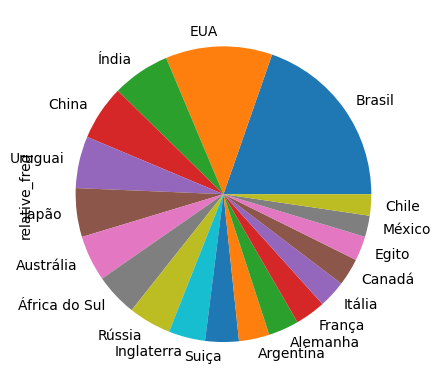

In [6]:
frequencies.relative_freq.plot.pie()

---

### Quantitativos

In [7]:
quant_df = (
    pd.read_excel(
        xl_path,
        sheet_name='Descritivas - Quantitativa',
        usecols=[0,1],
        nrows=100
    )
)
quant_df.head()

,Nº Observação,Preço ($)
0,1,189
1,2,195
2,3,199
3,4,189
4,5,197


In [8]:
(
    quant_df[['Preço ($)']].describe(percentiles=[.25,.75,.2,.6,.44,.85])
    .T
    .assign(
        amplitude=quant_df['Preço ($)'].max()-quant_df['Preço ($)'].min(),
        var=quant_df['Preço ($)'].var(),
        stderr=quant_df['Preço ($)'].sem(),
        cov=(quant_df['Preço ($)'].std()/quant_df['Preço ($)'].mean())*100,
        mode=quant_df['Preço ($)'].mode().values if len(quant_df['Preço ($)'].mode().values) == 1 else np.nan,
        skew=quant_df['Preço ($)'].skew(),
        kurtosis=quant_df['Preço ($)'].kurt(),
    )
    .round(4)
    .T
)

,Preço ($)
count,100.0000
mean,190.7700
std,15.6211
min,149.0000
20%,179.0000
25%,179.0000
44%,189.0000
50%,189.0000
60%,196.4000
75%,199.0000


PDF

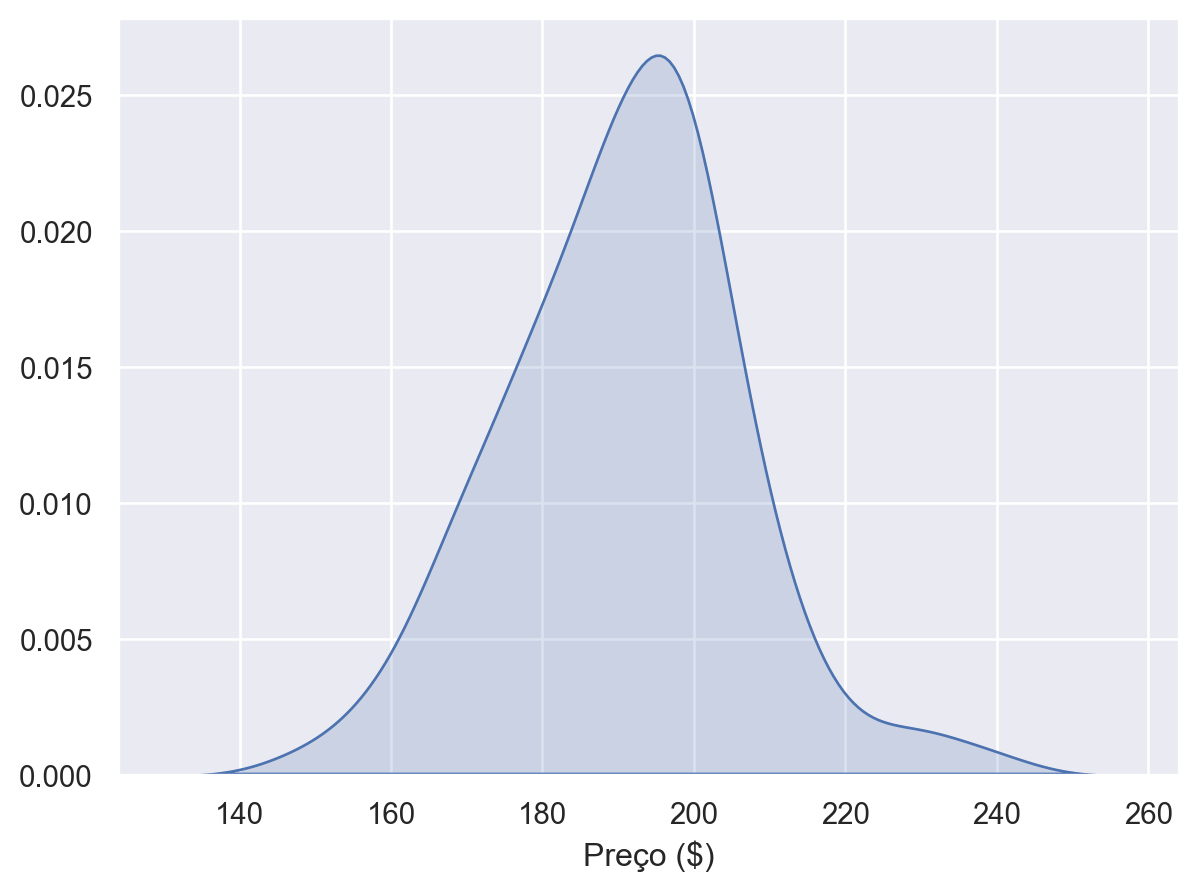

In [9]:
(
    so.Plot(quant_df, x='Preço ($)')
    .add(so.Area(), so.KDE())
)

CDF

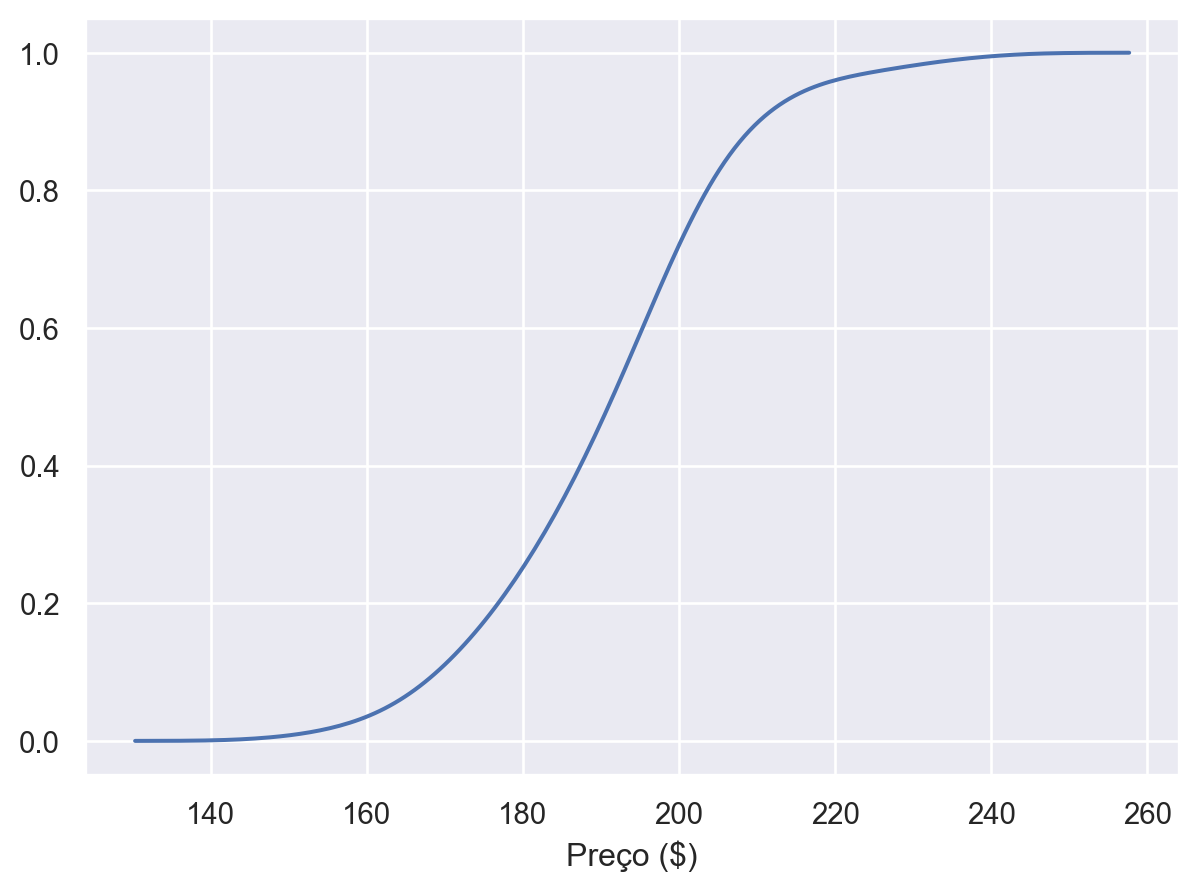

In [10]:
(
    so.Plot(quant_df, x='Preço ($)')
    .add(so.Line(), so.KDE(cumulative=True))
)

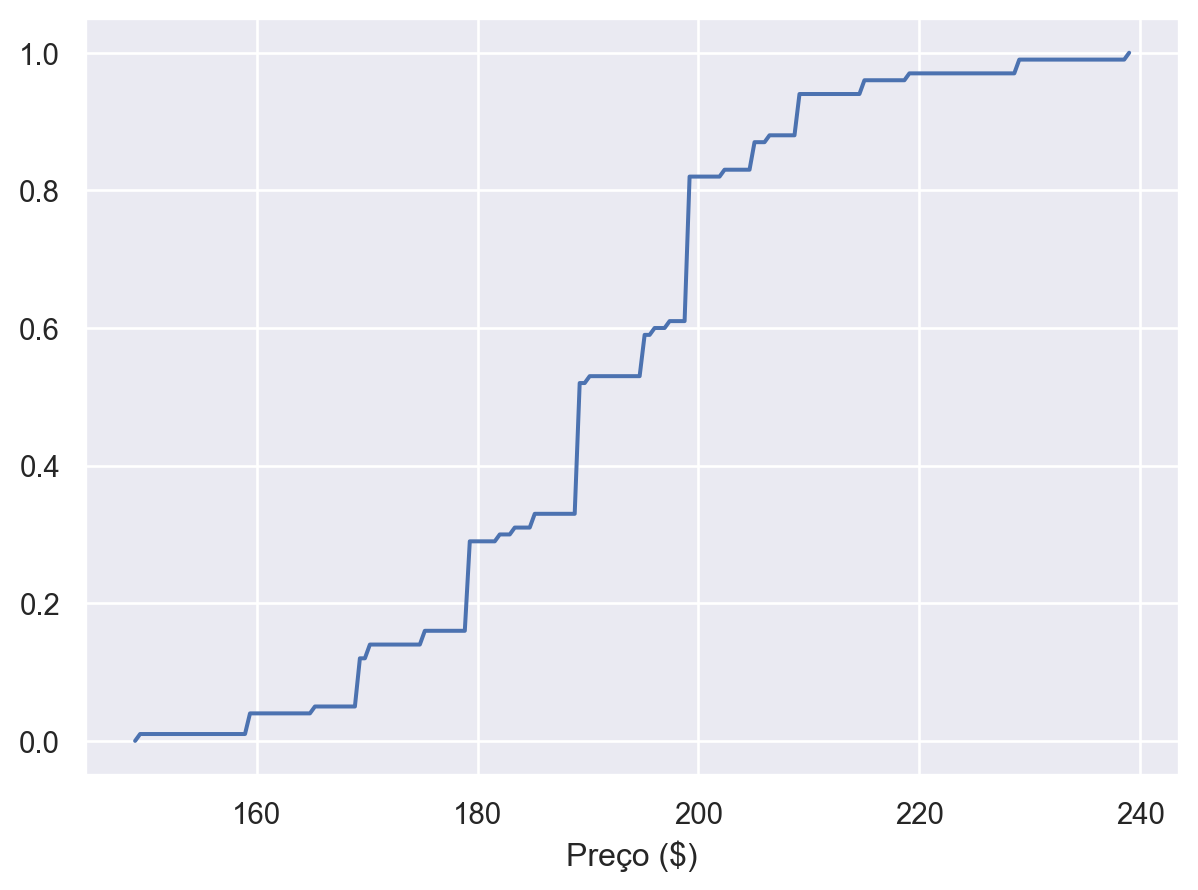

In [11]:
(
    so.Plot(quant_df, x='Preço ($)')
    .add(so.Line(), so.KDE(bw_adjust=1E-10, cumulative=True))
)

---

## Teste Qui²

In [12]:
chi_df = (
    pd.read_excel(
        xl_path,
        sheet_name='Associação - Qui²',
        usecols=[1,2,3,4],
        header=3,
        index_col=0,
        nrows=3,
    )
)
chi_df.head()

,Baixo,Médio,Alto
Total Health,40,16,12
Viva Vida,32,24,16
Mena Saúde,24,32,4


In [13]:
f_obs = (
    chi_df
    .stack()
)
f_obs

Total Health  Baixo    40
              Médio    16
              Alto     12
Viva Vida     Baixo    32
              Médio    24
              Alto     16
Mena Saúde    Baixo    24
              Médio    32
              Alto      4
dtype: int64

In [14]:
f_exp = (
    pd.concat([
        f_obs.groupby(level=0).sum(),
        f_obs.groupby(level=1).sum()
    ])
    .to_frame()
    .T
    .corr(method=lambda x,y: x*y/f_obs.sum())
    .stack()
    .loc[f_obs.index]
)
f_exp

Total Health  Baixo    32.64
              Médio    24.48
              Alto     10.88
Viva Vida     Baixo    34.56
              Médio    25.92
              Alto     11.52
Mena Saúde    Baixo    28.80
              Médio    21.60
              Alto      9.60
dtype: float64

In [15]:
ddof = 6-2
chi2val, pvalue = stats.chisquare(f_obs, f_exp, ddof=ddof)
critical05 = stats.chi2.ppf(1-.05, ddof)

In [16]:
print(f'''χ²: {chi2val:.3f}
pvalue: {pvalue:.4f}
Critical (.05): {critical05:.3f}
''')

χ²: 15.861
pvalue: 0.0032
Critical (.05): 9.488



---

## Distribuição t

$
\displaystyle f(t)={\frac {\ \Gamma \left({\frac {\ \nu +1\ }{2}}\right)\ }{\ {\sqrt {\pi \ \nu \ }}\ \Gamma \left({\frac {\nu }{2}}\right)}}\left(\ 1+{\frac {~t^{2}\ }{\nu }}\ \right)^{-(\nu +1)/2}
$, onde $\nu$ é o grau de liberdade e $\Gamma$ a função gamma.

In [17]:
sp = np.linspace(-4,4,200)

In [18]:
ddof_l = [1,4,8,24]

In [19]:
t = (
    pd.DataFrame({f'ν = {dof}':stats.t.pdf(sp, dof) for dof in ddof_l})
    .set_index(sp)
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'x', 'level_1': 'dof', 0: 'P(x)'})
)

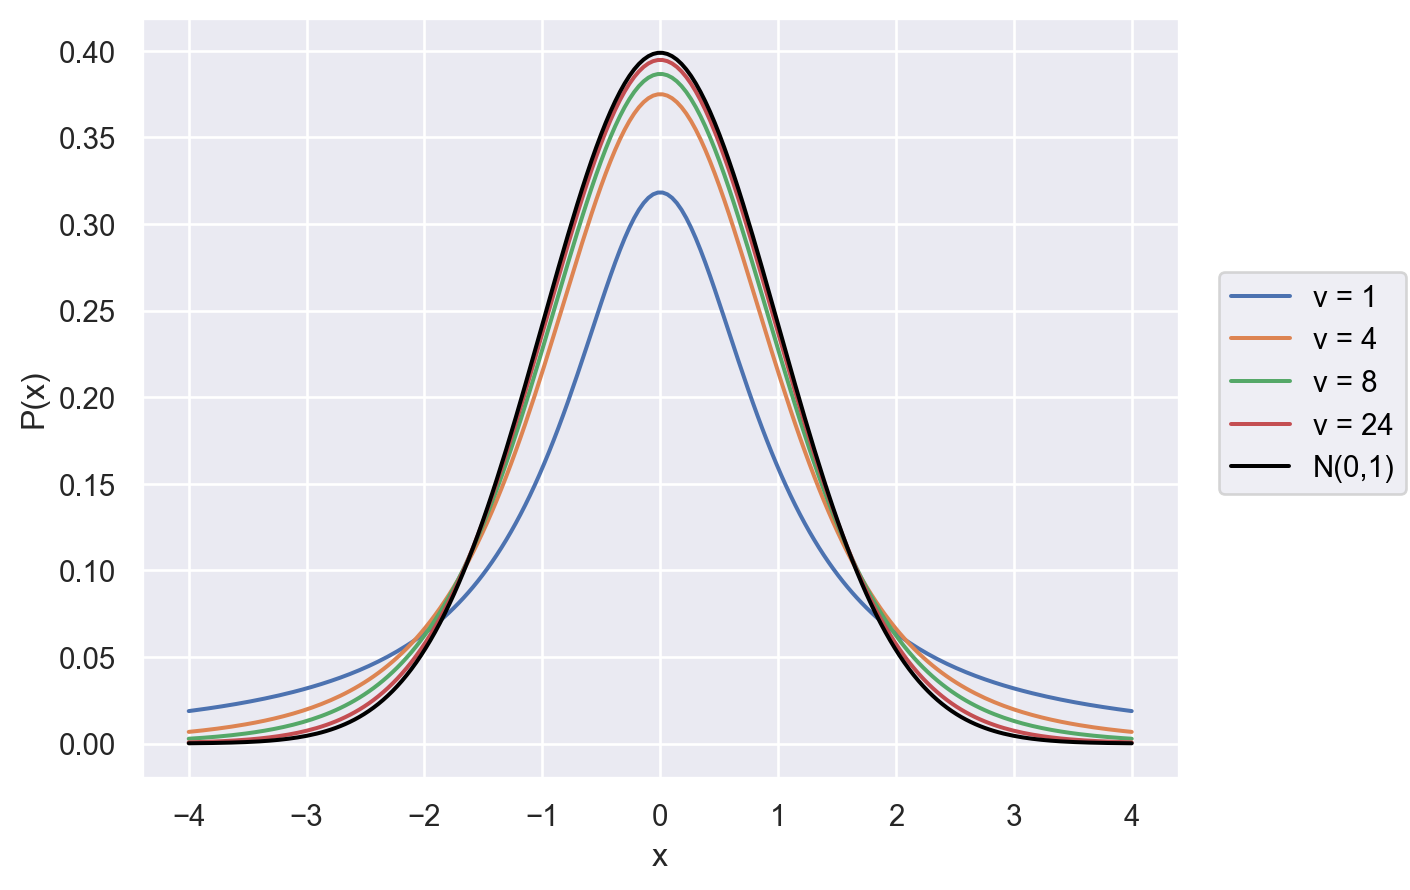

In [20]:
(
   so.Plot(t, x='x', y='P(x)')
    .add(so.Line(), color='dof')
    .add(
        so.Line(color='black'), 
        label='N(0,1)', 
        data=pd.DataFrame({'x': sp, 'P(x)': stats.norm.pdf(sp)}),
    )
    .label(
        color=''
    )
)

A medida que $ \displaystyle \ \nu \rightarrow \infty $, a distribuição t tende a$ \displaystyle \ {\mathcal {N}}(0,1) $

### Teste t de uma amostra 

$ \displaystyle t = \frac{\bar{x} - \mu _{0}}{s/\sqrt{n}} $

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/1/1b/One_sample_t-test.png" width="500"/>
</div>

### Teste t para o coeficiente de correlação

$ \displaystyle t=\frac{r}{\sqrt{(1-r^2)/(n-2)}} $

In [21]:
def ttest_corr(r, n):
    return r/np.sqrt((1-r**2)/(n-2))

---

## Distribuição normal

$ 
\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}} 
$

$ \displaystyle {\mathcal {N}}(\mu ,\sigma ^{2}) $

In [22]:
x = np.linspace(-4,4,100)

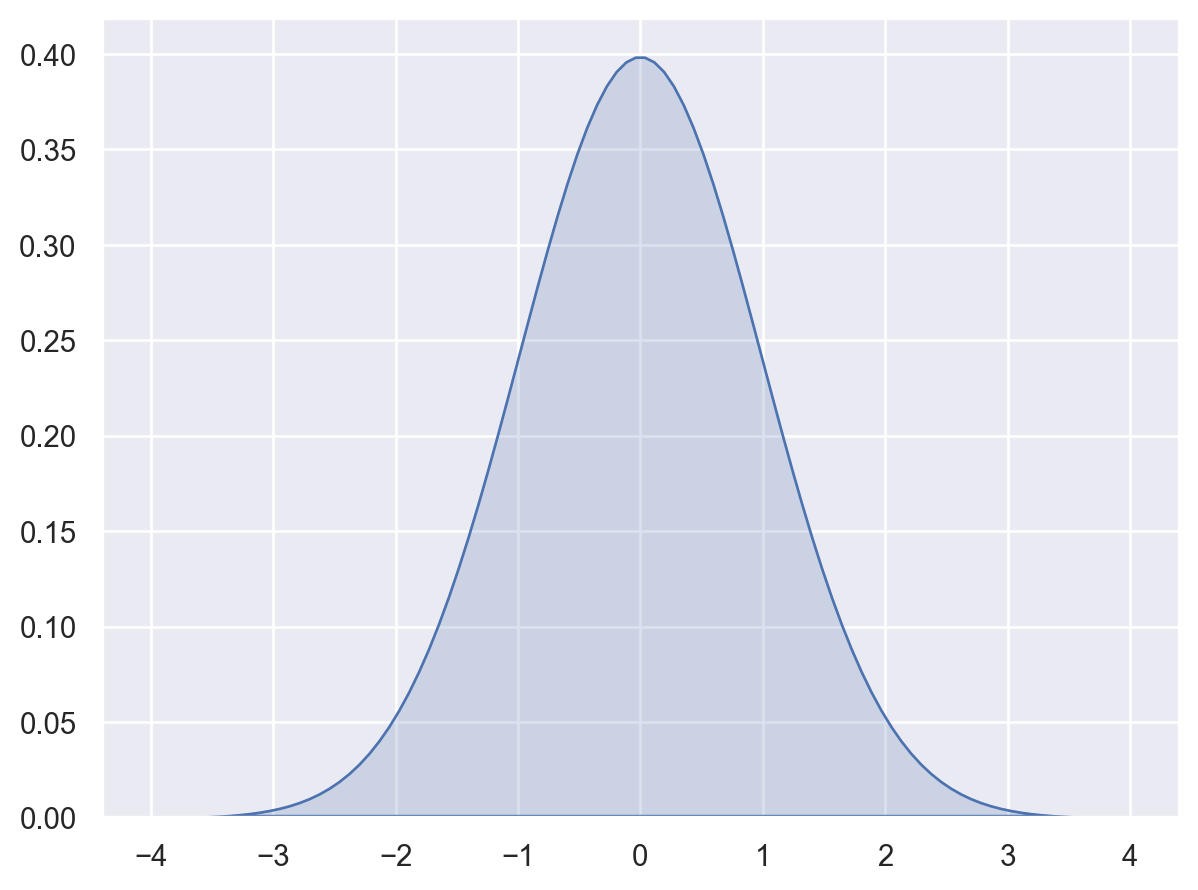

In [23]:
(
    so.Plot(x=x, y=stats.norm.pdf(x))
    .add(so.Area())
)

### Distribuição Z (normal padrão)

$ \displaystyle \ {\mathcal {N}}(0,1) $

Caso especial da distribuição normal onde o desvio padrão é 1 e a média 0.
Se pode converter um score (valor) $x$ a um Z-Score $z$, que nos diz a distância 
entre score $x$ e a média da população $\mu$ em unidades de $\sigma$. $z$ é 
positivo quando $x$ é maior que $\mu$ e negativo quando é menor.

$ \displaystyle z = \frac{x-\mu}{\sigma} $, onde $\mu$ é a média da população e $\sigma$ é o desvio padrão da população.

### Teste Z

$
\displaystyle Z = \frac{(\bar{X} - \mu)}{SE}
$

$ \displaystyle SE = \frac{\sigma}{\sqrt{n}} $

Distância entre a média amostral $ \bar{X} $ e a média da população $ \mu $ em unidades de erro padrão.

## Distribuição Binomial e Binomial Negativa

You're selling candy door-to-door. At each door you knock on, you have probability 1/4 of selling 1 candy bar and probability 3/4 or selling 0 candy bars. Your probability of selling n bars if you knock on 50 doors is a binomial distribution in n. Your probability of having to knock on m door in order to sell 30 bars is a negative binomial distribution in m. Note that the former cuts off at 50 because you can't sell more than 50 bars, while the latter has a tail at infinity because you could just have terrible luck that day and never sell the 30th bar.

---

## Correlação de Pearson

In [24]:
corrp_df = (
    pd.read_excel(
        xl_path,
        sheet_name='Correlação de Pearson',
        usecols=[1,2,3],
    )
)
corrp_df.head()

,Nota Matemática,Nota Física,Nota Literatura
0,5.5,7.5,9.0
1,9.0,8.5,5.5
2,4.5,5.0,6.5
3,6.5,8.0,6.5
4,7.5,6.0,5.0


In [25]:
corrp_df.agg(['mean','std'])

,Nota Matemática,Nota Física,Nota Literatura
mean,6.77500,6.866667,6.566667
std,2.05354,1.716720,1.715715


In [26]:
col_comb = list(combinations(corrp_df.columns, 2))

In [27]:
def corr_pvalue(a: np.ndarray, b: np.ndarray) -> float:
    pvalue = stats.pearsonr(a, b).pvalue
    return pvalue

In [28]:
def matrix_unstack_filt(
    df: pd.DataFrame, 
    matrix: typing.Callable,
    filt: typing.Iterable,
    **matrix_kwargs) -> pd.DataFrame:
    return df.pipe(matrix, **matrix_kwargs).unstack().loc[filt] 

In [29]:
unstack_filt_corrp = partial(matrix_unstack_filt, df=corrp_df, filt=col_comb)

In [30]:
(
    pd.DataFrame(index=pd.MultiIndex.from_tuples(col_comb))
    .assign(
        covar=unstack_filt_corrp(matrix=pd.DataFrame.cov),
        pearson=unstack_filt_corrp(matrix=pd.DataFrame.corr),
        r_pvalue=unstack_filt_corrp(matrix=partial(pd.DataFrame.corr, method=corr_pvalue)),
        ttest=lambda df: ttest_corr(r=df.pearson, n=30),
        critical05=lambda df: stats.t.isf(0.05/2, 28),
    )
)

covar   pearson  r_pvalue     ttest  \
Nota Matemática Nota Física      2.124138  0.602532  0.000426  3.994890   
                Nota Literatura -1.087931 -0.308783  0.096862 -1.717873   
Nota Física     Nota Literatura -0.852874 -0.289561  0.120647 -1.600792   

                                 critical05  
Nota Matemática Nota Física        2.048407  
                Nota Literatura    2.048407  
Nota Física     Nota Literatura    2.048407